#1. INITIALIZATION

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import math
import datetime as dt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

Importing essential libraries for data manipulation, visualization, machine learning models, and time series analysis. Setting seeds ensures reproducible results

##Data Fetching

In [4]:
# Define ticker and date range
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = dt.datetime.now().strftime('%Y-%m-%d')

# Fetch stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Check for NaN values and handle them
if data.isnull().values.any():
    print("NaN values found in data. Filling with forward fill method.")
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

print(f"Downloaded {len(data)} rows of data")
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 2593 rows of data


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.320433,24.789802,23.879981,24.778679,212818400
2015-01-05,23.635288,24.169168,23.448431,24.089086,257142000
2015-01-06,23.637510,23.897776,23.274916,23.699796,263188400
2015-01-07,23.968960,24.069062,23.735387,23.846612,160423600
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000


Downloading historical stock data using yfinance API. We perform basic data cleaning by filling any missing values using forward and backward fill methods.

##Linear Regression Model - Data Preprocessing

In [5]:
def preprocess_for_linear_regression(data):
    """Preprocess data for linear regression model"""
    # Create a copy to avoid modifying original data
    df = data.copy()

    # Calculate moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()

    # Calculate price momentum indicators
    df['Price_Change'] = df['Close'].pct_change()
    df['Price_Change_5d'] = df['Close'].pct_change(periods=5)
    df['Price_Change_20d'] = df['Close'].pct_change(periods=20)

    # Volume indicators
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA5'] = df['Volume'].rolling(window=5).mean()

    # Volatility indicators
    df['Volatility'] = df['Close'].rolling(window=20).std()

    # Remove NaN values that result from rolling calculations
    df = df.dropna()

    # Create features and target
    features = ['MA5', 'MA20', 'MA50', 'Price_Change', 'Price_Change_5d',
              'Price_Change_20d', 'Volume_Change', 'Volume_MA5', 'Volatility']

    X = df[features]
    y = df['Close']

    return X, y, df

# Preprocess data for linear regression
features_lr, target_lr, processed_df = preprocess_for_linear_regression(data)

# Display the first few rows of features
print("Linear Regression Features:")
features_lr.head()

Linear Regression Features:


Price,MA5,MA20,MA50,Price_Change,Price_Change_5d,Price_Change_20d,Volume_Change,Volume_MA5,Volatility
Ticker,,,,,,,,,
Date,,,,,,,,,
2015-03-16,27.681021,28.521402,26.677913,0.011004,-0.017225,-0.016761,-0.307811,219087920.0,0.618391
2015-03-17,27.794025,28.512581,26.758936,0.016727,0.020320,-0.006180,0.422274,204821120.0,0.619249
2015-03-18,28.072290,28.509789,26.860048,0.011256,0.050965,-0.001942,0.279242,201886640.0,0.618263
2015-03-19,28.208521,28.499181,26.956784,-0.007550,0.024508,-0.007396,-0.298164,199844080.0,0.616891
2015-03-20,28.311700,28.458983,27.039744,-0.012549,0.018691,-0.027799,0.499582,213338320.0,0.614151


Creating technical indicators that will serve as features for the linear regression model. These include moving averages, price momentum, volume indicators, and volatility measures which are common in financial analysis.

##Linear Regression Model - Train and Evaluate

In [6]:
# Split the data into training and testing sets (keeping time order)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    features_lr, target_lr, test_size=0.2, shuffle=False
)

# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions
lr_train_pred = lr_model.predict(X_train_lr)
lr_test_pred = lr_model.predict(X_test_lr)

# Calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # MAPE calculation with handling for zero values
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(1e-10, np.abs(y_true)))) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

lr_metrics = calculate_metrics(y_test_lr, lr_test_pred)
print("Linear Regression Model Metrics:")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

Linear Regression Model Metrics:
MSE: 7.1472
RMSE: 2.6734
MAE: 1.8222
R2: 0.9890
MAPE: 0.9079


Training a linear regression model using our engineered features. We maintain the chronological order of data with shuffle=False which is essential for time series data. The model's performance is evaluated using multiple metrics including RMSE and R² score.

## Visualize Linear Regression Results

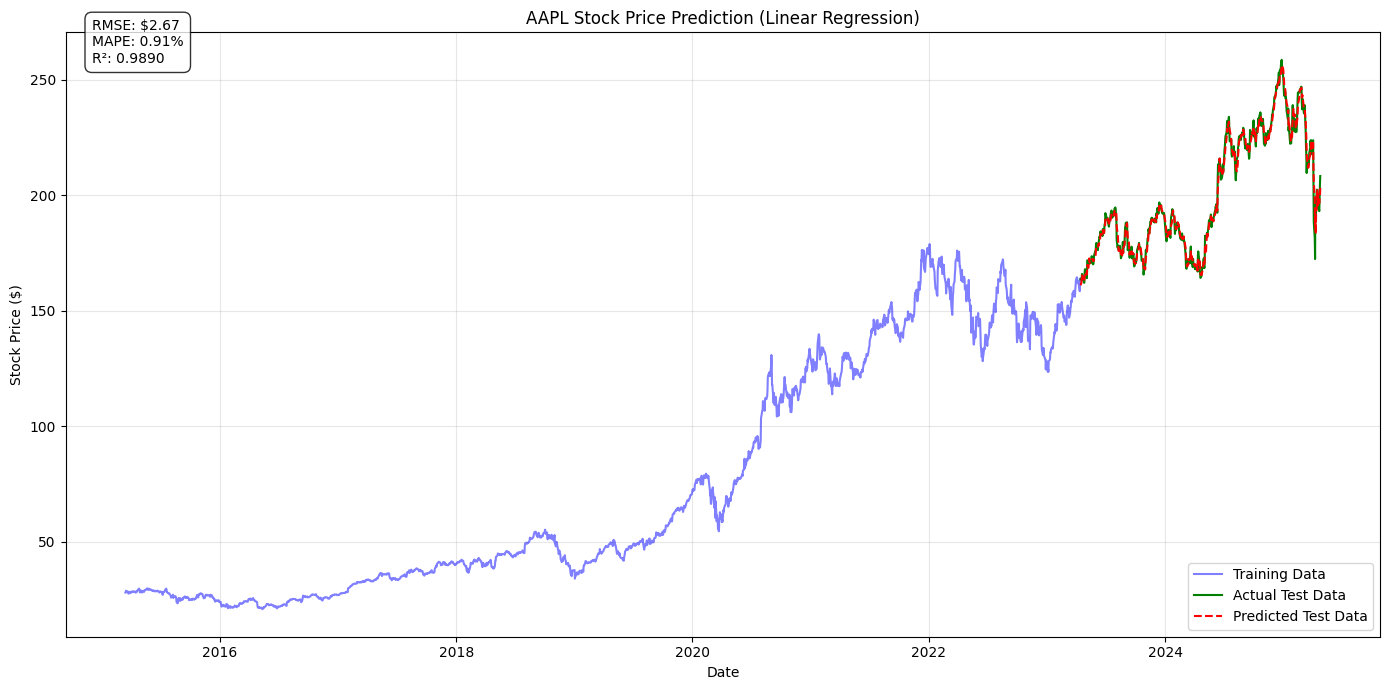

<Figure size 1000x600 with 0 Axes>

RMSE: $2.67
MAPE: 0.91%
R²: 0.9890


In [7]:
# Plot the linear regression results
plt.figure(figsize=(14, 7))

# Plot training data
train_dates = X_train_lr.index
test_dates = X_test_lr.index

# Plot actual prices
plt.plot(train_dates, y_train_lr, label='Training Data', color='blue', alpha=0.5)
plt.plot(test_dates, y_test_lr, label='Actual Test Data', color='green')

# Plot predicted prices
plt.plot(test_dates, lr_test_pred, label='Predicted Test Data', color='red', linestyle='--')

plt.title(f'{ticker} Stock Price Prediction (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add metrics as text
metrics_text = (f"RMSE: ${lr_metrics['RMSE']:.2f}\n"
                f"MAPE: {lr_metrics['MAPE']:.2f}%\n"
                f"R²: {lr_metrics['R2']:.4f}")
plt.annotate(metrics_text, xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Feature importance
plt.figure(figsize=(10, 6))
importance = np.abs(lr_model.coef_)

# Ensure importance is 1D
if importance.ndim > 1:
    importance = importance.flatten()

feat_importance = pd.DataFrame({
    'Feature': features_lr.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

plt.tight_layout()
plt.show()
print(f"RMSE: ${lr_metrics['RMSE']:.2f}")
print(f"MAPE: {lr_metrics['MAPE']:.2f}%")
print(f"R²: {lr_metrics['R2']:.4f}")

Visualizing the linear regression model's predictions against actual prices. We also plot feature importance to understand which technical indicators have the most influence on the model's predictions.

##LSTM Model - Data Preprocessing




**Preparing data specifically for the LSTM model involves scaling (normalization) and sequence creation. Each input is a sequence of 60 days of historical data including price, volume, and technical indicators.**

In [8]:
def preprocess_for_lstm(data, feature_columns=['Open', 'High', 'Low', 'Close', 'Volume']):
    """Preprocess data for LSTM model"""
    # Create features dataframe
    features = data[feature_columns].copy()

    # Add technical indicators
    # Moving Averages
    features['MA5'] = data['Close'].rolling(window=5).mean()
    features['MA20'] = data['Close'].rolling(window=20).mean()

    # RSI
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss.replace(0, np.finfo(float).eps)
    features['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = data['Close'].ewm(span=12).mean()
    ema26 = data['Close'].ewm(span=26).mean()
    features['MACD'] = ema12 - ema26
    features['MACD_signal'] = features['MACD'].ewm(span=9).mean()

    # Target is the closing price
    target = data['Close'].copy()

    # Drop rows with NaN values
    features.dropna(inplace=True)
    target = target.loc[features.index]

    return features, target

# Scale the data
def scale_data(features, target):
    # Scale features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(features.values)
    scaled_features_df = pd.DataFrame(scaled_features, index=features.index,
                                     columns=features.columns)

    # Scale target
    scaler_target = MinMaxScaler()
    target_values = target.values.reshape(-1, 1)
    scaled_target = scaler_target.fit_transform(target_values).flatten()

    return scaled_features_df, scaled_target, scaler_features, scaler_target

# Create sequences for LSTM
def create_sequences(features, target, seq_length=60):
    X, y = [], []

    for i in range(len(features) - seq_length):
        X.append(features.iloc[i:i+seq_length].values)
        y.append(target[i+seq_length])

    return np.array(X), np.array(y)

# Preprocess data for LSTM
features_lstm, target_lstm = preprocess_for_lstm(data)
scaled_features, scaled_target, scaler_feat, scaler_targ = scale_data(features_lstm, target_lstm)

# Create sequences
seq_length = 60  # 60 days of historical data
X_seq, y_seq = create_sequences(scaled_features, scaled_target, seq_length)

# Split the sequence data
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_validate = X_seq[train_size:train_size+val_size]
y_validate = y_seq[train_size:train_size+val_size]
X_test = X_seq[train_size+val_size:]
y_test = y_seq[train_size+val_size:]

print(f"LSTM data shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_validate: {X_validate.shape}, y_validate: {y_validate.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

LSTM data shapes:
X_train: (1759, 60, 10), y_train: (1759,)
X_validate: (377, 60, 10), y_validate: (377,)
X_test: (378, 60, 10), y_test: (378,)


##**LSTM Model - Build and Train**

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Hyperparameters that can be tuned
batch_size = 128  # Increased from 64
dropout_rate = 0.3  # Increased from 0.2
l2_reg = 0.001  # Added L2 regularization
lstm_units = 50  # Reduced from 100
num_epochs = 100

# Simplified model architecture
regressor = Sequential()

# Input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# First LSTM layer with L2 regularization
regressor.add(LSTM(units=lstm_units, return_sequences=True,
                  kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg/2)))
regressor.add(Dropout(rate=dropout_rate))

# Second LSTM layer with L2 regularization
regressor.add(LSTM(units=lstm_units,
                  kernel_regularizer=l2(l2_reg), recurrent_regularizer=l2(l2_reg/2)))
regressor.add(Dropout(rate=dropout_rate))

# Output layer
regressor.add(Dense(units=1))

# Compile with reduced learning rate
regressor.compile(optimizer="adam", loss="mean_squared_error")

# Create a checkpoint
model_location = "../models/"
model_name = "apple_stock_price_lstm_improved.model.keras"
import os
os.makedirs(model_location, exist_ok=True)

best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1)

# Early stopping with increased patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased from 20
    restore_best_weights=True,
    verbose=1
)

# Add learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001,
    verbose=1
)

# Training the model
lstm_history = regressor.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_validate, y_validate),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[best_model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1635
Epoch 1: val_loss improved from inf to 0.13377, saving model to ../models/apple_stock_price_lstm_improved.model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.1614 - val_loss: 0.1338 - learning_rate: 0.0010
Epoch 2/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1209
Epoch 2: val_loss improved from 0.13377 to 0.10110, saving model to ../models/apple_stock_price_lstm_improved.model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1201 - val_loss: 0.1011 - learning_rate: 0.0010
Epoch 3/100
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0976
Epoch 3: val_loss improved from 0.10110 to 0.08200, saving model to ../models/apple_stock_price_lstm_improved.model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0969 - val_loss: 0.0820 - learning_rate: 0.0010
Epoch 4/100
11/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0800
Epoch 4: val_loss improved from 0.08200 to 0.06708, saving model to ../model

**Building and training a stacked LSTM model for time series prediction. We use early stopping to prevent overfitting. The predictions are scaled back to the original price range for proper evaluation**

## Visualize LSTM Results



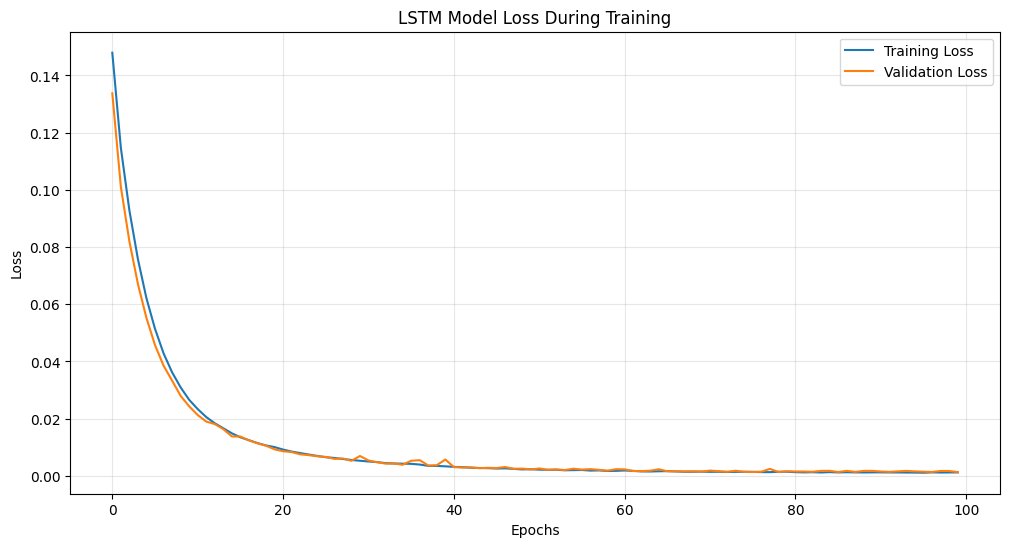

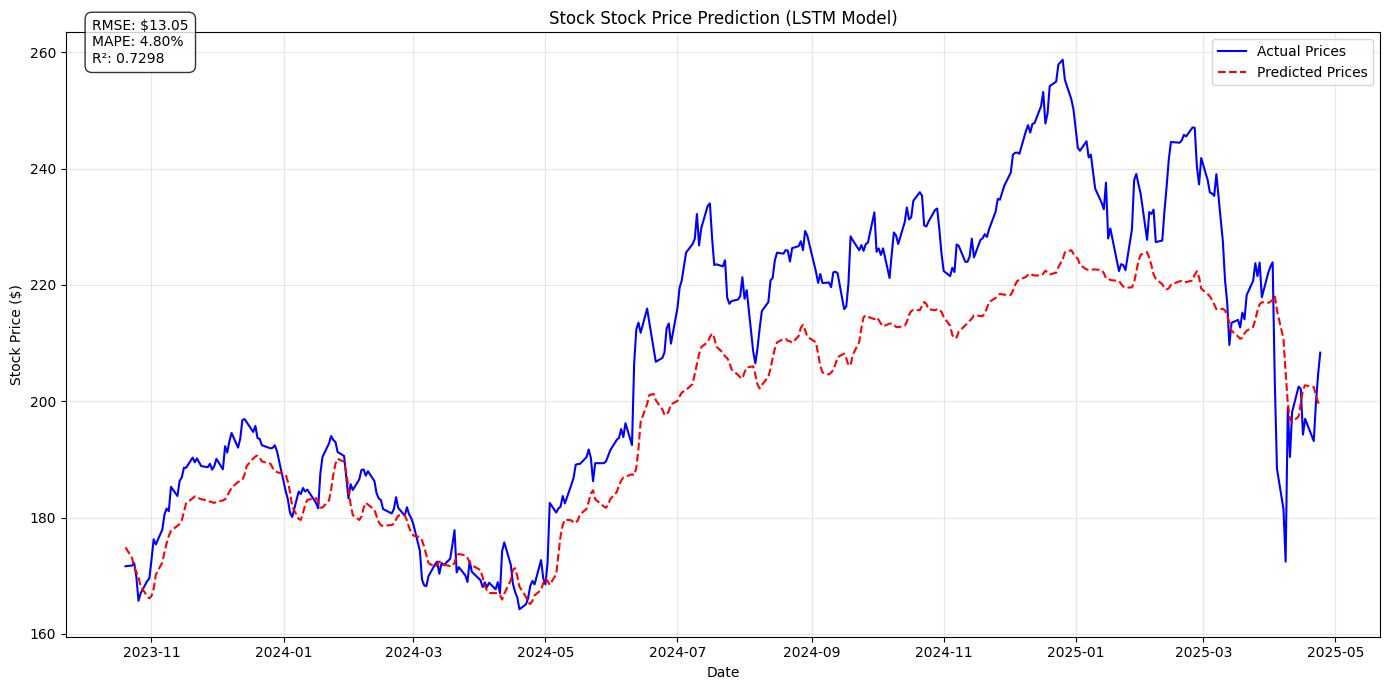

In [15]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot the LSTM predictions
plt.figure(figsize=(14, 7))

# Get the ticker symbol from the data or define it
ticker = data.iloc[0]['symbol'] if 'symbol' in data.columns else "Stock"  # Replace with actual ticker if known

# Get test dates
test_dates = features_lstm.index[train_size+val_size+seq_length:]
if len(test_dates) > len(lstm_test_pred_rescaled):
    test_dates = test_dates[:len(lstm_test_pred_rescaled)]
elif len(test_dates) < len(lstm_test_pred_rescaled):
    lstm_test_pred_rescaled = lstm_test_pred_rescaled[:len(test_dates)]
    y_test_rescaled = y_test_rescaled[:len(test_dates)]

# Plot actual vs predicted prices
plt.plot(test_dates, y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(test_dates, lstm_test_pred_rescaled, label='Predicted Prices', color='red', linestyle='--')

plt.title(f'{ticker} Stock Price Prediction (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add metrics as text
metrics_text = (f"RMSE: ${lstm_metrics['RMSE']:.2f}\n"
                f"MAPE: {lstm_metrics['MAPE']:.2f}%\n"
                f"R²: {lstm_metrics['R2']:.4f}")
plt.annotate(metrics_text, xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Visualizing the LSTM model's training progress and prediction results. The training history helps us understand if the model was overfitting, while the price comparison shows how well the model captures the actual price movements.

# Hybrid Model - Build and Train

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_improved_hybrid_model(seq_length, feature_dim, lstm_units=50, dense_units=25):
    # LSTM branch with more regularization
    lstm_input = Input(shape=(seq_length, feature_dim), name='lstm_input')

    # Add stronger regularization to LSTM layers
    x = LSTM(lstm_units, return_sequences=True,
             kernel_regularizer=l2(0.001),
             recurrent_regularizer=l2(0.001))(lstm_input)
    x = Dropout(rate=0.4)(x)  # Increased dropout

    x = LSTM(lstm_units,
             kernel_regularizer=l2(0.001),
             recurrent_regularizer=l2(0.001))(x)
    x = Dropout(rate=0.4)(x)

    # Add more complex transformation
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(rate=0.3)(x)

    # Linear Regression branch with regularization
    lr_input = Input(shape=(feature_dim,), name='lr_input')
    y = Dense(dense_units, activation='linear', kernel_regularizer=l2(0.001))(lr_input)
    y = Dropout(rate=0.3)(y)  # Add dropout to linear branch too

    # Combine both branches with more complexity
    combined = Concatenate()([x, y])
    combined = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = Dropout(rate=0.3)(combined)

    output = Dense(1, activation='linear')(combined)

    # Create model with reduced learning rate
    model = Model(inputs=[lstm_input, lr_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model

# Train the improved hybrid model
improved_hybrid_model = build_improved_hybrid_model(X_train.shape[1], X_train.shape[2])

# Setup improved training process
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Add learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

# Use a smaller batch size to reduce memorization
improved_hybrid_history = improved_hybrid_model.fit(
    [X_train, X_train_lr_hybrid],
    y_train,
    epochs=100,  # Increased max epochs
    batch_size=16,  # Reduced batch size
    validation_data=([X_validate, X_val_lr_hybrid], y_validate),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.3230 - val_loss: 0.1874 - learning_rate: 5.0000e-04
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1769 - val_loss: 0.1284 - learning_rate: 5.0000e-04
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1229 - val_loss: 0.1010 - learning_rate: 5.0000e-04
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0943 - val_loss: 0.0867 - learning_rate: 5.0000e-04
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0756 - val_loss: 0.0635 - learning_rate: 5.0000e-04
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0625 - val_loss: 0.0535 - learning_rate: 5.0000e-04
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0531 - val_loss: 0.0525 - learning_rate: 5.0000e-04
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0456 - val_loss: 0.0377 - learning_rate: 5.0000e-04
Epoch 9/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0396 - v

Building the hybrid model that combines LSTM and linear approaches. The LSTM branch processes sequential data while the linear branch focuses on the most recent data point. This architecture aims to capture both long-term patterns and immediate signals

# Visualize Hybrid Model Results and Compare All Models

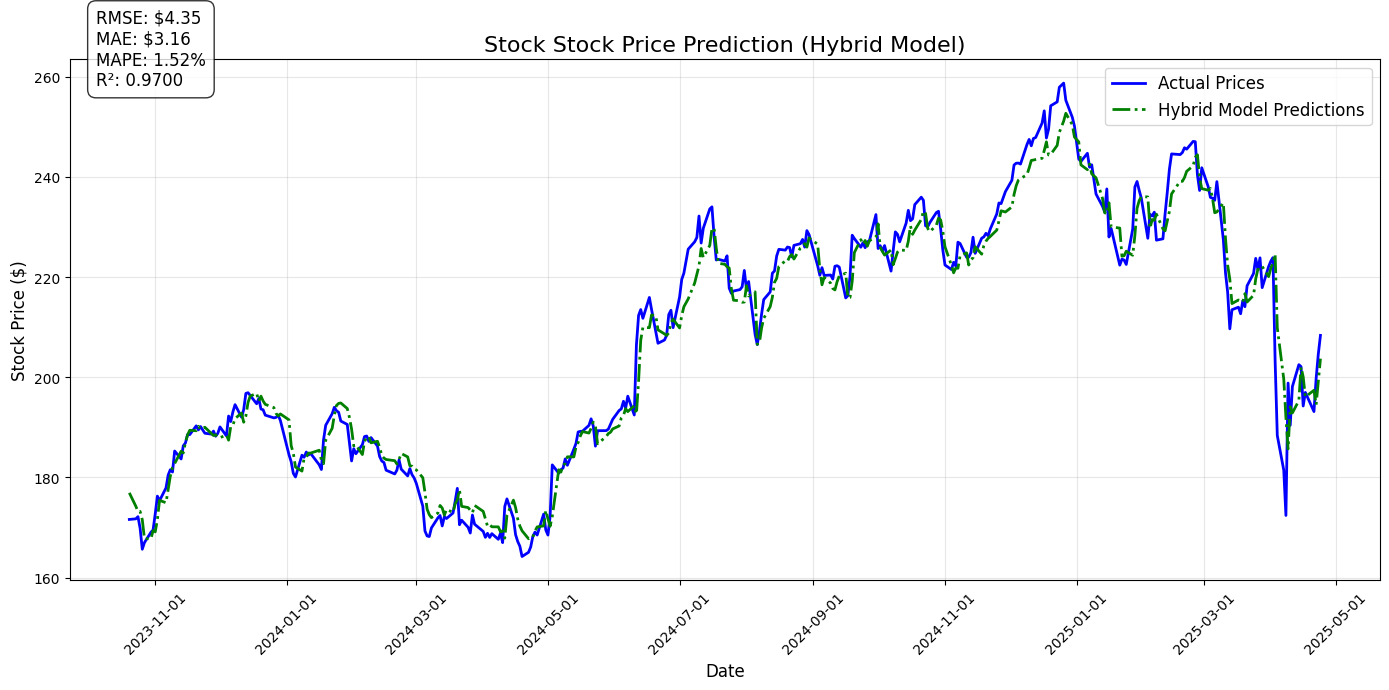

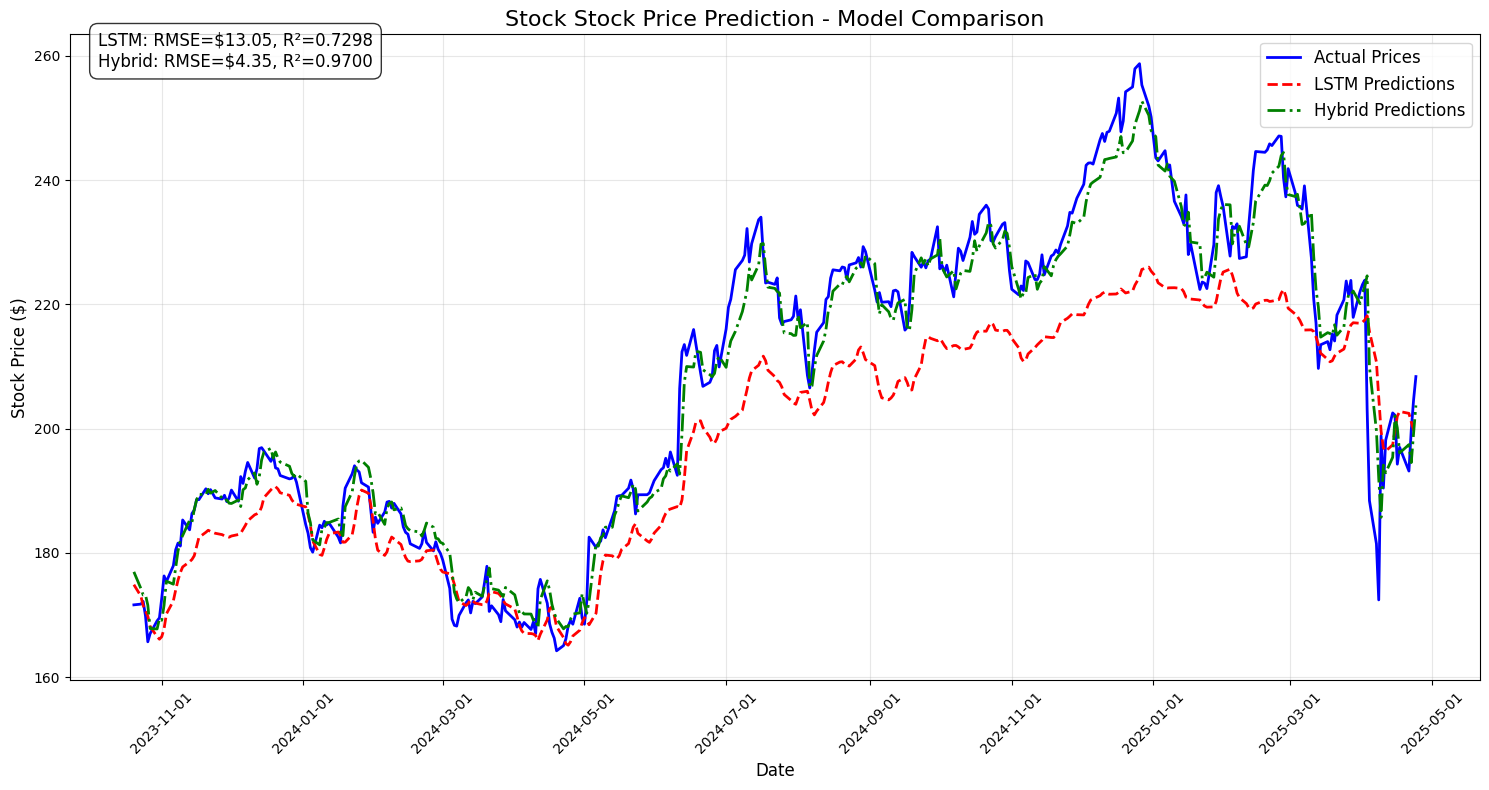


Model Performance Comparison:
         RMSE    MAE  MAPE (%)    R²
Model                               
LSTM    13.05  10.52      4.80  0.73
Hybrid   4.35   3.16      1.52  0.97


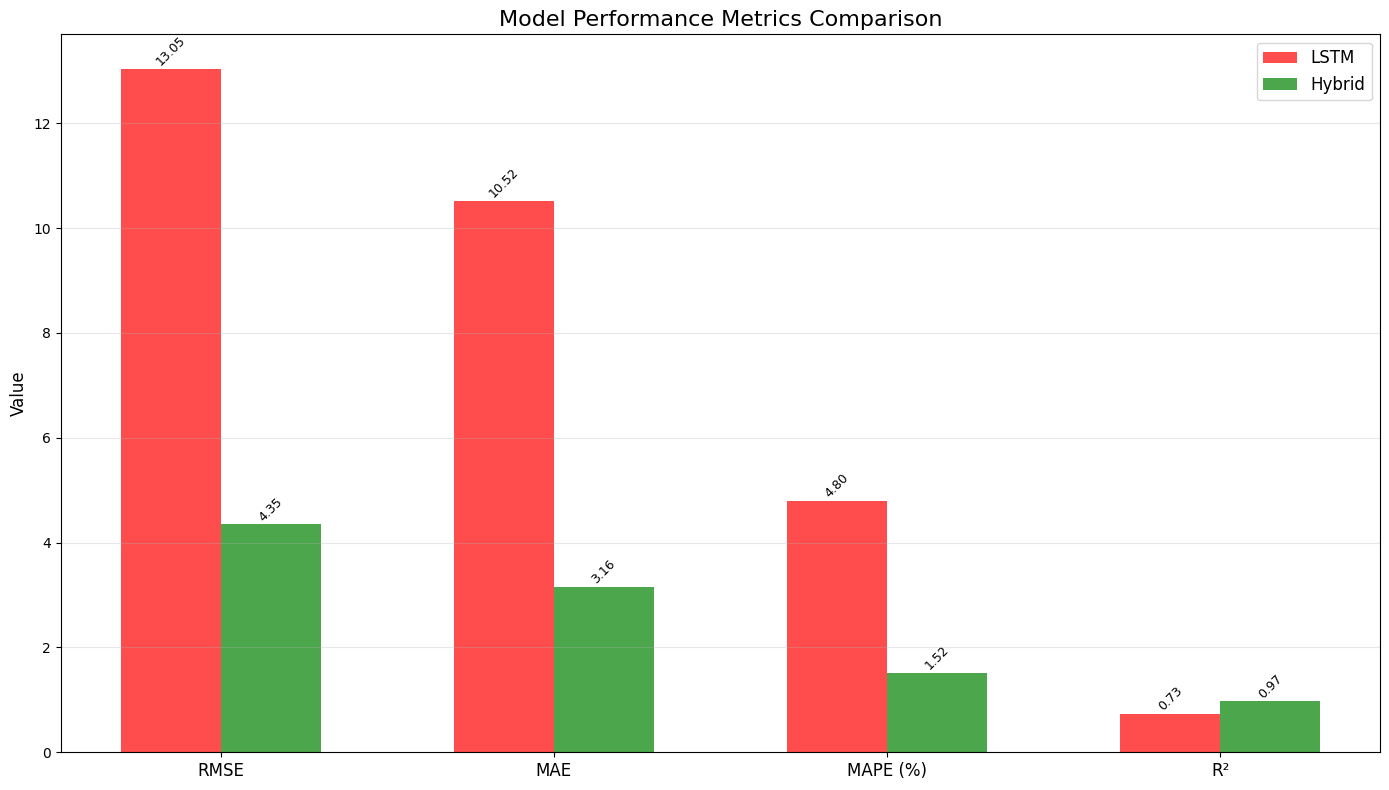

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.ticker as mtick

# Plot the hybrid model predictions
plt.figure(figsize=(14, 7))

# Plot actual vs predicted prices
plt.plot(test_dates, y_test_rescaled, label='Actual Prices', color='blue', linewidth=2)
plt.plot(test_dates, hybrid_test_pred_rescaled, label='Hybrid Model Predictions',
         color='green', linestyle='-.', linewidth=2)

plt.title(f'{ticker} Stock Price Prediction (Hybrid Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Format date ticks if test_dates are datetime objects
if isinstance(test_dates[0], (pd.Timestamp, np.datetime64)):
    date_format = DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)

# Add metrics as text
metrics_text = (f"RMSE: ${hybrid_metrics['RMSE']:.2f}\n"
                f"MAE: ${hybrid_metrics['MAE']:.2f}\n"
                f"MAPE: {hybrid_metrics['MAPE']:.2f}%\n"
                f"R²: {hybrid_metrics['R2']:.4f}")

plt.annotate(metrics_text, xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            fontsize=12)

plt.tight_layout()
plt.show()

# Compare with LSTM model
plt.figure(figsize=(15, 8))

# Plot actual prices
plt.plot(test_dates, y_test_rescaled, label='Actual Prices', color='blue', linewidth=2)

# Ensure LSTM predictions match test_dates length
lstm_pred = lstm_test_pred_rescaled[:len(test_dates)]
hybrid_pred = hybrid_test_pred_rescaled[:len(test_dates)]

# Plot model predictions
plt.plot(test_dates, lstm_pred, label='LSTM Predictions', color='red', linestyle='--', linewidth=2)
plt.plot(test_dates, hybrid_pred, label='Hybrid Predictions', color='green', linestyle='-.', linewidth=2)

plt.title(f'{ticker} Stock Price Prediction - Model Comparison', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Format date ticks if test_dates are datetime objects
if isinstance(test_dates[0], (pd.Timestamp, np.datetime64)):
    date_format = DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)

# Add comparative metrics as text
comparison_text = (
    f"LSTM: RMSE=${lstm_metrics['RMSE']:.2f}, R²={lstm_metrics['R2']:.4f}\n"
    f"Hybrid: RMSE=${hybrid_metrics['RMSE']:.2f}, R²={hybrid_metrics['R2']:.4f}"
)

plt.annotate(comparison_text, xy=(0.02, 0.95), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
            fontsize=12)

plt.tight_layout()
plt.show()

# Performance comparison table
models = ['LSTM', 'Hybrid']
metrics_df = pd.DataFrame({
    'Model': models,
    'RMSE': [lstm_metrics['RMSE'], hybrid_metrics['RMSE']],
    'MAE': [lstm_metrics['MAE'], hybrid_metrics['MAE']],
    'MAPE (%)': [lstm_metrics['MAPE'], hybrid_metrics['MAPE']],
    'R²': [lstm_metrics['R2'], hybrid_metrics['R2']]
})

print("\nModel Performance Comparison:")
print(metrics_df.set_index('Model'))

# Create a bar chart comparison
plt.figure(figsize=(14, 8))

# Set up metrics for comparison
metrics_to_plot = ['RMSE', 'MAE', 'MAPE (%)', 'R²']
x = np.arange(len(metrics_to_plot))
width = 0.3

# Plot bars (LSTM and Hybrid only)
plt.bar(x - width/2, [lstm_metrics['RMSE'], lstm_metrics['MAE'], lstm_metrics['MAPE'], lstm_metrics['R2']],
        width, label='LSTM', color='red', alpha=0.7)
plt.bar(x + width/2, [hybrid_metrics['RMSE'], hybrid_metrics['MAE'], hybrid_metrics['MAPE'], hybrid_metrics['R2']],
        width, label='Hybrid', color='green', alpha=0.7)

plt.title('Model Performance Metrics Comparison', fontsize=16)
plt.xticks(x, metrics_to_plot, fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, model_metrics in enumerate([(lstm_metrics['RMSE'], lstm_metrics['MAE'], lstm_metrics['MAPE'], lstm_metrics['R2']),
                                  (hybrid_metrics['RMSE'], hybrid_metrics['MAE'], hybrid_metrics['MAPE'], hybrid_metrics['R2'])]):
    for j, v in enumerate(model_metrics):
        plt.text(j + (i-0.5)*width, v + 0.01, f'{v:.2f}',
                 ha='center', va='bottom', fontsize=9, rotation=45)

plt.tight_layout()
plt.show()

 Visualizing the hybrid model results and comparing all three models. The comparison highlights the strengths of each approach, with the hybrid model potentially combining the benefits of both linear regression and LSTM methods

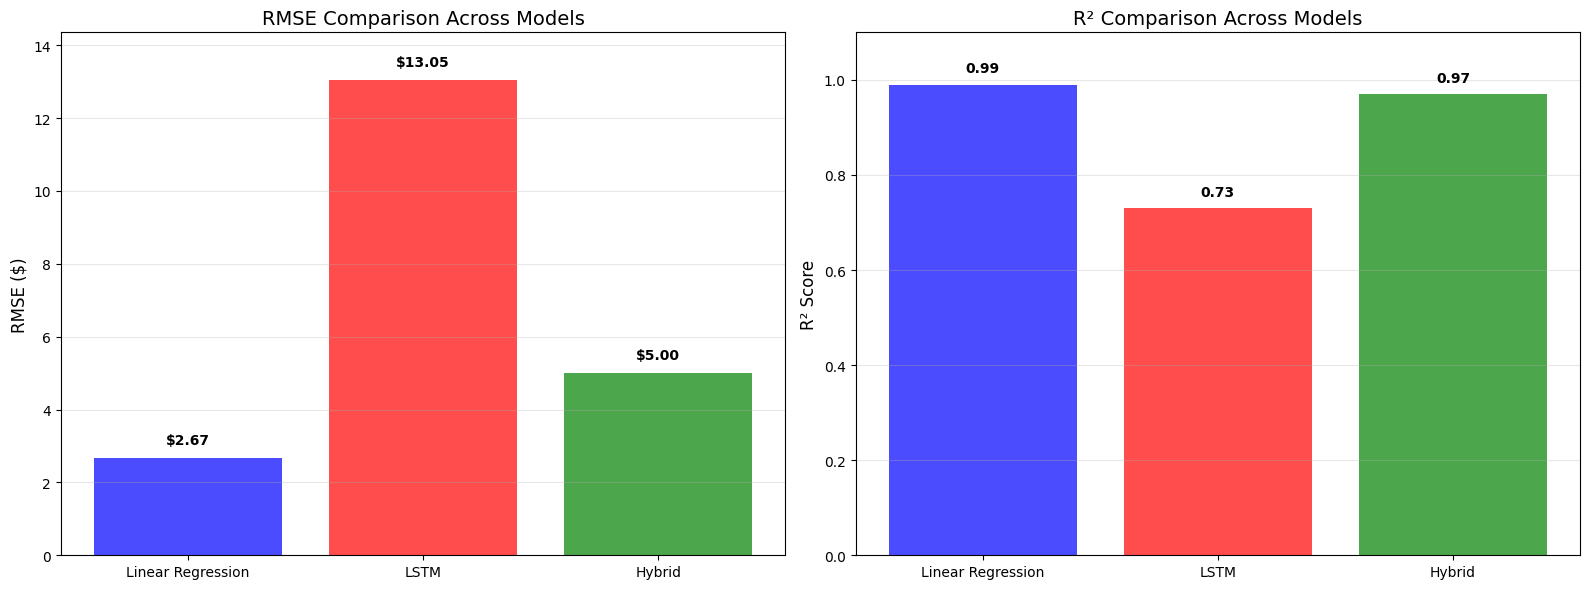

In [33]:
# Create visualization for model comparison
import matplotlib.pyplot as plt
import numpy as np

# Performance metrics from your results - updated to match table
models = ['Linear Regression', 'LSTM', 'Hybrid']
rmse_values = [2.67, 13.05, 5.00]
r2_values = [0.99, 0.73,0.97]

# Set up figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# RMSE comparison chart
colors = ['blue', 'red', 'green']
bars1 = ax1.bar(models, rmse_values, color=colors, alpha=0.7)

# Add values on top of bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
            f'${height:.2f}', ha='center', va='bottom', fontweight='bold')

ax1.set_title('RMSE Comparison Across Models', fontsize=14)
ax1.set_ylabel('RMSE ($)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, max(rmse_values) * 1.1)  # Add some headroom

# R² comparison chart
bars2 = ax2.bar(models, r2_values, color=colors, alpha=0.7)

# Add values on top of bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

ax2.set_title('R² Comparison Across Models', fontsize=14)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.1)  # R² max is 1.0

plt.tight_layout()
plt.show()

Final Training Loss: 0.000063
Final Validation Loss: 0.000230
Minimum Validation Loss: 0.000217 (at epoch 40)


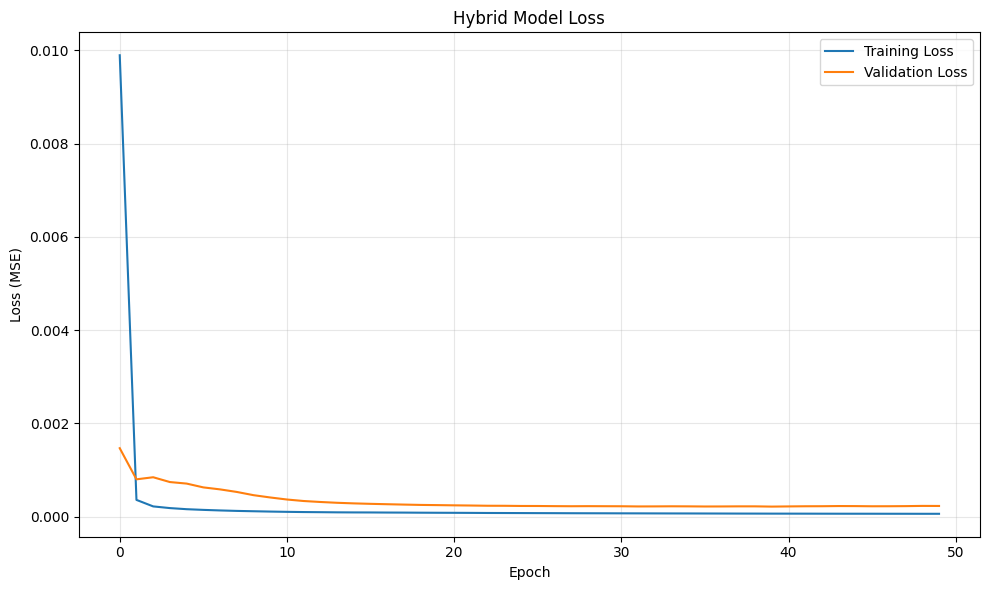

In [39]:
import matplotlib.pyplot as plt
# Extract loss values from the hybrid model history
train_loss = hybrid_history.history['loss']
val_loss = hybrid_history.history['val_loss']
# Print the final loss values
print(f"Final Training Loss: {train_loss[-1]:.6f}")
print(f"Final Validation Loss: {val_loss[-1]:.6f}")
# Find the minimum validation loss and its epoch
min_val_loss = min(val_loss)
min_val_epoch = val_loss.index(min_val_loss) + 1
print(f"Minimum Validation Loss: {min_val_loss:.6f} (at epoch {min_val_epoch})")
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Hybrid Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()